In [2]:
pip install keras-rl

     |████████████████████████████████| 40 kB 3.8 MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-py3-none-any.whl size=48380 sha256=3b594e6b6e942fa454e6e2e2d6148617dd7d6ac50bddc1dc0c1c70e3bb35c338
  Stored in directory: /root/.cache/pip/wheels/d3/23/e9/278c2e59c322236e2bfdf7c792c16f0b4dec24816d27a3f1e4
Successfully built keras-rl


Importing packages

In [3]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [5]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
env.observation_space.n

500

In [7]:
env.action_space.n

6

In [8]:
env.env.s = 122
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [9]:
env.step(3)

(102, -1, False, {'prob': 1.0})

In [10]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


In [11]:
env.reset()
env.env.P[300]

{0: [(1.0, 400, -1, False)],
 1: [(1.0, 200, -1, False)],
 2: [(1.0, 300, -1, False)],
 3: [(1.0, 300, -1, False)],
 4: [(1.0, 300, -10, False)],
 5: [(1.0, 300, -10, False)]}

RANDOM SEARCH

In [13]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

Text(0.5, 1.0, 'Distribution of number of steps needed')

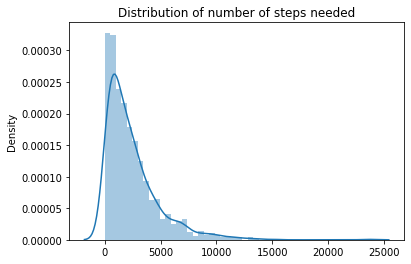

In [14]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")

In [15]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2443 steps to successfully complete its mission.


Policy Iteration/Value Iteration

In [16]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.env.nS)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.env.nS):  #for all states
            val = 0  #initiate value as 0
            
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for a in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    while True:
        # Implement this!
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.env.nS):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.env.nA)[best_act]  #update 
        if policy_stable:
            return policy, curr_pol_val
    
    return policy, np.zeros(env.env.nS)

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for act in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.env.nS, env.env.nA])
    for state in range(env.env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

In [17]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
policy_eval(random_policy,env,discount_factor=0.95)

array([-66.26438752, -71.80792647, -71.42078771, -71.82385699,
       -79.85874125, -79.76644406, -79.85914609, -79.85320521,
       -78.94845049, -78.98965515, -78.18067178, -78.9907127 ,
       -79.89007096, -79.88569714, -79.8903011 , -79.81473063,
       -58.97388718, -71.28332886, -70.42368566, -71.3187026 ,
       -71.76849805, -75.09061994, -74.85861632, -75.10016676,
       -79.84505188, -79.74379722, -79.84549601, -79.83897851,
       -79.0763058 , -79.11250001, -78.40188794, -79.11342896,
       -79.87942213, -79.87462379, -79.87967461, -79.79676993,
       -67.0351757 , -74.29222689, -73.47645597, -74.33919453,
       -79.64432128, -79.7878237 , -79.77780243, -79.78823608,
       -77.71728288, -76.22431024, -77.72383134, -77.6277274 ,
       -79.84088218, -79.84711324, -79.72477359, -79.84727316,
       -79.40240042, -79.37859483, -79.40365295, -78.99236538,
       -76.72709833, -73.48229756, -76.82709925, -76.20673132,
       -79.71298147, -79.82877523, -79.82068901, -79.82

In [18]:
pol_iter_policy = policy_iteration(env,policy_eval,discount_factor=0.99)
pol_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [19]:
val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [20]:
for x in range(len(pol_iter_policy[0])):
    if not (pol_iter_policy[0][x] == val_iter_policy[0][x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy


In [21]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

An agent using a policy which has been improved using policy-iterated takes about an average of 13 steps to successfully complete its mission.


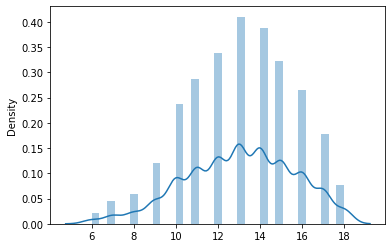

In [22]:
pol_count = count(pol_iter_policy[0])
pol_counts = [count(pol_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been improved using policy-iterated takes about an average of " + str(int(np.mean(pol_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(pol_counts)

An agent using a policy which has been value-iterated takes about an average of 13 steps to successfully complete its mission.


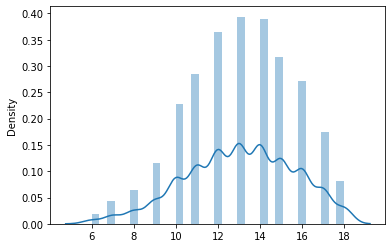

In [23]:
val_count = count(val_iter_policy[0])
val_counts = [count(val_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(val_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(val_counts)

Q-learning

In [24]:
import random
from IPython.display import clear_output

def Q_learning_train(env,alpha,gamma,epsilon,episodes): 
    """Q Learning Algorithm with epsilon greedy 

    Args:
        env: Environment 
        alpha: Learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma: Discount Rate --> How much importance we want to give to future rewards
        epsilon: Probability of selecting random action instead of the 'optimal' action
        episodes: No. of episodes to train on

    Returns:
        Q-learning Trained policy

    """
    %%time
    """Training the agent"""

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    
    #Initialize Q table of 500 x 6 size (500 states and 6 actions) with all zeroes
    q_table = np.zeros([env.observation_space.n, env.action_space.n])  
    
    for i in range(1, episodes+1):
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space randomly
            else:
                action = np.argmax(q_table[state]) # Exploit learned values by choosing optimal values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  #for each states
        best_act = np.argmax(q_table[state]) #find best action
        policy[state] = np.eye(env.env.nA)[best_act]  #update 
        
    print("Training finished.\n")
    return policy, q_table

In [25]:
env = gym.make('Taxi-v3')
env.reset()
Q_learn_pol = Q_learning_train(env,0.2,0.95,0.1,100000)

Episode: 100000
Training finished.



An agent using a policy which has been improved using Q-learning takes about an average of 12 steps to successfully complete its mission.


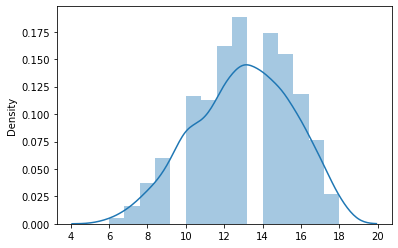

In [26]:
Q_Learning_counts = count(Q_learn_pol[0])
Q_counts = [count(Q_learn_pol[0]) for i in range(1000)]
print("An agent using a policy which has been improved using Q-learning takes about an average of " + str(int(np.mean(Q_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(Q_counts)

Result

In [27]:
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[0][curr_state])) 
        curr_state = state
        counter += 1
        env.env.s = curr_state
        env.render()

In [28]:
view_policy(pol_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y|

In [29]:
view_policy(val_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y

In [30]:
view_policy(Q_learn_pol)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y

In [43]:
from IPython.display import clear_output

from matplotlib import animation
from IPython.display import display


def view_policy_anim(policy):
    penalties, reward = 0, 0

    frames = [] # for animation

    done = False
    curr_state = env.reset()
    while not done:
        action = np.argmax(policy[0][curr_state])
        state, reward, done, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        print(frames)
    def print_frames(frames):
        
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(.7)

    print_frames(frames)

In [44]:
view_policy_anim(val_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 18
State: 85
Action: 5
Reward: 20


In [45]:
view_policy_anim(pol_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 13
State: 410
Action: 5
Reward: 20


In [46]:
view_policy_anim(Q_learn_pol)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 9
State: 410
Action: 5
Reward: 20
